<h2>Решение тестового задания №1 от Курагина Максима</h2>
<h3>В данном ноутбуке решается задача по прогнозированию динамики подключений, отключений и сальдо.</h3>
<h3>В ходе решения был выполнен препроцессинг данных с изменением формата даты и созданием новых фичей.</h3>
<h3>При анализе данных и построении первых прогнозов было выявлено, что строить прогноз на данных с подневной разбивкой нежелательно и качество предсказаний на месячных данных лучше.</h3>
<h3>Вычисление сальдо было произведено после пронозов подключений и отключений с учетом спрогнозированных чисел.</h3>

# Импорты и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_json('задание DA №1.json')
df

,id клиента,id счета,Дата рождения,Пол,Клиент подключил услугу,Клиент отключил услугу
0,1236,3000,1976-11-02,0.0,2020-09-22 19:36:56,2021-09-10 19:24:19
1,1314,3001,1979-10-21,1.0,2020-04-29 11:13:18,NaT
2,1248,3002,1964-11-15,1.0,2020-09-30 14:48:46,2021-04-30 10:26:50
3,2053,3003,1979-09-12,0.0,2020-03-03 17:10:30,2020-09-10 16:19:03
4,2016,3004,1973-03-23,0.0,2019-08-19 13:24:27,2019-11-28 15:49:09
...,...,...,...,...,...,...
1360,1718,4200,1971-08-06,1.0,2020-12-25 16:30:12,2021-04-12 13:13:26
1361,1687,4201,1977-08-28,0.0,2020-10-26 14:30:20,NaT
1362,1296,4202,1985-03-07,1.0,2020-12-15 13:06:57,2021-08-03 11:24:08
1363,1372,4203,1981-10-26,0.0,2020-09-10 16:22:13,2021-08-17 18:02:26


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1364
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id клиента               1365 non-null   int64  
 1   id счета                 1365 non-null   int64  
 2   Дата рождения            1365 non-null   object 
 3   Пол                      1362 non-null   float64
 4   Клиент подключил услугу  1365 non-null   object 
 5   Клиент отключил услугу   1365 non-null   object 
dtypes: float64(1), int64(2), object(3)
memory usage: 74.6+ KB


# Препроцессинг

## Обработка данных и новые переменные 

In [4]:
# 1 - если человек до сих пор пользуется, 0 - если человек уже отключил услугу
df['Статус пользования'] = df['Клиент отключил услугу'].apply(
    lambda x: 1 if  x == 'NaT' else 0)                                                           

In [6]:
# заполним значения NaT сегодняшней датой для удобства дальнейшего анализа 
data_now = format(dt.datetime.now())[:-7]
df['Клиент отключил услугу'].replace('NaT', data_now, inplace=True)

In [7]:
# поменяем формат даты рождения на datetime
df['Дата рождения'] = df['Дата рождения'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d').date())

In [8]:
# разделим дату и время 
df['День подключения услуги'] = df['Клиент подключил услугу'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
df['Время подключение услуги'] = df['Клиент подключил услугу'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time())

df['День отключения услуги'] = df['Клиент отключил услугу'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
df['Время отключения услуги'] = df['Клиент отключил услугу'].apply(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').time())

In [9]:
# удалим старый формат даты и времени
del df['Клиент подключил услугу'], df['Клиент отключил услугу']

In [10]:
# вычислим возраст подключения и отключения услуги
df['Возраст подключения'] = df['День подключения услуги'].apply(
    lambda x: x.year) - df['Дата рождения'].apply(lambda x: x.year)
df['Возраст отключения'] = df['День отключения услуги'].apply(
    lambda x: x.year) - df['Дата рождения'].apply(lambda x: x.year)

In [11]:
# вычислим кол-во лет, месяцев и дней пользования услуги
df['Кол-во лет пользования'] = df['День отключения услуги'].apply(
    lambda x: x.year) - df['День подключения услуги'].apply(lambda x: x.year)

df['Кол-во дней пользования'] = [(i - y).days for i, y in zip(
    df['День отключения услуги'], df['День подключения услуги'])]

df['Кол-во месяцев пользования'] = df['Кол-во дней пользования'].apply(lambda x: int(x / 30))

## Заполнение пропущенных значений

In [12]:
# посмотрим на переменную Пол и значения, где Пол отсутствует
print(df['Пол'].unique())
print(df['Пол'].value_counts())
df[pd.isnull(df['Пол'])]

[ 0.  1. nan]
0.0    966
1.0    396
Name: Пол, dtype: int64


,id клиента,id счета,Дата рождения,Пол,Статус пользования,День подключения услуги,Время подключение услуги,День отключения услуги,Время отключения услуги,Возраст подключения,Возраст отключения,Кол-во лет пользования,Кол-во дней пользования,Кол-во месяцев пользования
359,1515,3318,2004-06-20,NaN,0,2020-09-10,11:54:00,2020-12-03,13:22:41,16,16,0,84,2
548,1310,3487,2008-04-11,NaN,0,2020-12-25,17:33:56,2021-08-23,13:41:26,12,13,1,241,8
895,1138,3796,2015-06-09,NaN,0,2020-12-10,15:29:28,2021-08-23,16:50:06,5,6,1,256,8


In [13]:
# удивительно, что Пол отсутствует у трех самых молодых клиентов 
df.sort_values('Дата рождения', ascending=False).head(10)

,id клиента,id счета,Дата рождения,Пол,Статус пользования,День подключения услуги,Время подключение услуги,День отключения услуги,Время отключения услуги,Возраст подключения,Возраст отключения,Кол-во лет пользования,Кол-во дней пользования,Кол-во месяцев пользования
895,1138,3796,2015-06-09,NaN,0,2020-12-10,15:29:28,2021-08-23,16:50:06,5,6,1,256,8
548,1310,3487,2008-04-11,NaN,0,2020-12-25,17:33:56,2021-08-23,13:41:26,12,13,1,241,8
359,1515,3318,2004-06-20,NaN,0,2020-09-10,11:54:00,2020-12-03,13:22:41,16,16,0,84,2
993,1062,3869,2001-09-21,0.0,0,2020-12-03,14:36:55,2021-02-25,13:09:16,19,20,1,84,2
476,1433,3420,2000-08-26,0.0,1,2020-11-19,17:23:48,2022-04-13,09:44:19,20,22,2,510,17
766,1080,3687,2000-08-25,0.0,0,2020-10-26,14:40:03,2021-03-30,11:30:01,20,21,1,155,5
566,1164,3505,1999-11-04,0.0,0,2020-09-04,16:40:18,2022-03-10,18:12:51,21,23,2,552,18
140,1340,3128,1999-09-10,0.0,0,2020-09-24,16:51:26,2021-05-13,09:20:00,21,22,1,231,7
1244,1384,4097,1999-08-02,0.0,0,2020-06-05,18:42:28,2020-09-15,18:26:48,21,21,0,102,3
781,1279,3700,1999-05-07,1.0,1,2020-06-25,16:56:51,2022-04-13,09:44:19,21,23,2,657,21


In [14]:
# проанализируем кол-во людей с полом 0 и 1, которые подключались в то же время
date_range_connection = pd.date_range('2020-09-10', '2020-12-25').tolist()
gender_0, gender_1 = 0, 0

for i, y in zip(df['Пол'], df['День подключения услуги']):
    if y in date_range_connection:
        if i == 0:
            gender_0 += 1
        if i == 1:
            gender_1 +=1

print(f'В диапозоне дат 2020.09.10 - 2020.12.25 подключения людей с полом 0 было: {gender_0}, а с полом 1: {gender_1}')

В диапозоне дат 2020.09.10 - 2020.12.25 подключения людей с полом 0 было: 438, а с полом 1: 205


/var/folders/zd/1t6xzv6j49383jt7cym9bd980000gn/T/ipykernel_67390/100961977.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if y in date_range_connection:


In [15]:
# проанализируем кол-во людей с полом 0 и 1, которые отключались в то же время
date_range_shutdown = pd.date_range('2020-12-03', '2021-08-23').tolist()
gender_0, gender_1 = 0, 0

for i, y in zip(df['Пол'], df['День отключения услуги']):
    if y in date_range_shutdown:
        if i == 0:
            gender_0 += 1
        if i == 1:
            gender_1 +=1
        
print(f'В диапозоне дат 2020.12.03 - 2021.08.23 отключений людей с полом 0 было: {gender_0}, а с полом 1: {gender_1}')

В диапозоне дат 2020.12.03 - 2021.08.23 отключений людей с полом 0 было: 349, а с полом 1: 147


/var/folders/zd/1t6xzv6j49383jt7cym9bd980000gn/T/ipykernel_67390/1366199259.py:6: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if y in date_range_shutdown:


In [16]:
# т.к. везде преобладает пол 0, заполним пропущенные значения полом 0 и проверим
df['Пол'] = df['Пол'].fillna(0)
print(df['Пол'].unique())
print(df['Пол'].value_counts())

[0. 1.]
0.0    969
1.0    396
Name: Пол, dtype: int64


## Итог препроцессинга 

In [17]:
df

,id клиента,id счета,Дата рождения,Пол,Статус пользования,День подключения услуги,Время подключение услуги,День отключения услуги,Время отключения услуги,Возраст подключения,Возраст отключения,Кол-во лет пользования,Кол-во дней пользования,Кол-во месяцев пользования
0,1236,3000,1976-11-02,0.0,0,2020-09-22,19:36:56,2021-09-10,19:24:19,44,45,1,353,11
1,1314,3001,1979-10-21,1.0,1,2020-04-29,11:13:18,2022-04-13,09:44:19,41,43,2,714,23
2,1248,3002,1964-11-15,1.0,0,2020-09-30,14:48:46,2021-04-30,10:26:50,56,57,1,212,7
3,2053,3003,1979-09-12,0.0,0,2020-03-03,17:10:30,2020-09-10,16:19:03,41,41,0,191,6
4,2016,3004,1973-03-23,0.0,0,2019-08-19,13:24:27,2019-11-28,15:49:09,46,46,0,101,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,1718,4200,1971-08-06,1.0,0,2020-12-25,16:30:12,2021-04-12,13:13:26,49,50,1,108,3
1361,1687,4201,1977-08-28,0.0,1,2020-10-26,14:30:20,2022-04-13,09:44:19,43,45,2,534,17
1362,1296,4202,1985-03-07,1.0,0,2020-12-15,13:06:57,2021-08-03,11:24:08,35,36,1,231,7
1363,1372,4203,1981-10-26,0.0,0,2020-09-10,16:22:13,2021-08-17,18:02:26,39,40,1,341,11


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1365 entries, 0 to 1364
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id клиента                  1365 non-null   int64  
 1   id счета                    1365 non-null   int64  
 2   Дата рождения               1365 non-null   object 
 3   Пол                         1365 non-null   float64
 4   Статус пользования          1365 non-null   int64  
 5   День подключения услуги     1365 non-null   object 
 6   Время подключение услуги    1365 non-null   object 
 7   День отключения услуги      1365 non-null   object 
 8   Время отключения услуги     1365 non-null   object 
 9   Возраст подключения         1365 non-null   int64  
 10  Возраст отключения          1365 non-null   int64  
 11  Кол-во лет пользования      1365 non-null   int64  
 12  Кол-во дней пользования     1365 non-null   int64  
 13  Кол-во месяцев пользования  1365 

In [19]:
df.to_csv('Данные после препроцессинга.csv')

# Вычисление фичей с кол-во клиентов 

## Вычисление

In [20]:
# создадим датафрейм с количеством подключенных в день клиентов 
df_connection = df.groupby(['День подключения услуги']).count().reset_index().iloc[:, :2]
df_connection = df_connection.rename(columns={'id клиента': 'Кол-во клиентов'})
df_connection

,День подключения услуги,Кол-во клиентов
0,2019-03-14,1
1,2019-03-22,1
2,2019-03-25,1
3,2019-04-01,1
4,2019-04-02,1
...,...,...
366,2020-12-25,14
367,2020-12-26,1
368,2020-12-28,9
369,2020-12-29,9


In [21]:
# создадим датафрейм с количеством отключенных в день клиентов 
df_shutdown = df.groupby(['День отключения услуги']).count().reset_index().iloc[:-1, :2]
df_shutdown = df_shutdown.rename(columns={'id клиента': 'Кол-во клиентов'})
df_shutdown

,День отключения услуги,Кол-во клиентов
0,2019-03-22,1
1,2019-04-09,1
2,2019-04-11,1
3,2019-04-23,1
4,2019-05-17,1
...,...,...
518,2022-03-31,2
519,2022-04-01,1
520,2022-04-04,2
521,2022-04-05,1


In [22]:
print('Первая дата подключения: ' + str(df_connection['День подключения услуги'].min()))
print('Последняя дата подключения: ' + str(df_connection['День подключения услуги'].max()))
print('Первая дата отключения: ' + str(df_shutdown['День отключения услуги'].min()))
print('Последняя дата отключения: ' + str(df_shutdown['День отключения услуги'].max()))

Первая дата подключения: 2019-03-14
Последняя дата подключения: 2020-12-30
Первая дата отключения: 2019-03-22
Последняя дата отключения: 2022-04-07


In [33]:
# создадим датафрейм от самой первой даты до самой последней
date_range = pd.date_range('2019-03-14', '2022-04-07')
df_all_date = pd.DataFrame(date_range, columns=['Все даты'])
df_all_date['Все даты'] = [i.date() for i in df_all_date['Все даты']]
df_all_date

,Все даты
0,2019-03-14
1,2019-03-15
2,2019-03-16
3,2019-03-17
4,2019-03-18
...,...
1116,2022-04-03
1117,2022-04-04
1118,2022-04-05
1119,2022-04-06


In [34]:
# объединим и обработаем три датафрейма для удобной работы
df_all_date = df_all_date.merge(
    df_connection, left_on = 'Все даты', right_on = 'День подключения услуги', how='left').merge(
    df_shutdown, left_on = 'Все даты', right_on = 'День отключения услуги', how='left')

df_all_date = df_all_date.rename(columns={'Кол-во клиентов_x': 'Кол-во подключенных клиентов', 
                                          'Кол-во клиентов_y': 'Кол-во отключенных клиентов'})

del df_all_date['День подключения услуги'], df_all_date['День отключения услуги']
df_all_date = df_all_date.fillna(0)
df_all_date.to_csv('Данные с кол-во клиентов.csv')
df_all_date

,Все даты,Кол-во подключенных клиентов,Кол-во отключенных клиентов
0,2019-03-14,1.0,0.0
1,2019-03-15,0.0,0.0
2,2019-03-16,0.0,0.0
3,2019-03-17,0.0,0.0
4,2019-03-18,0.0,0.0
...,...,...,...
1116,2022-04-03,0.0,0.0
1117,2022-04-04,0.0,2.0
1118,2022-04-05,0.0,1.0
1119,2022-04-06,0.0,0.0


## Визуализация

In [56]:
# уберем дату в индекс 
df_for_visualization = df_all_date.copy()
df_for_visualization.set_index('Все даты', inplace = True)
df_for_visualization.index = pd.to_datetime(df_for_visualization.index)

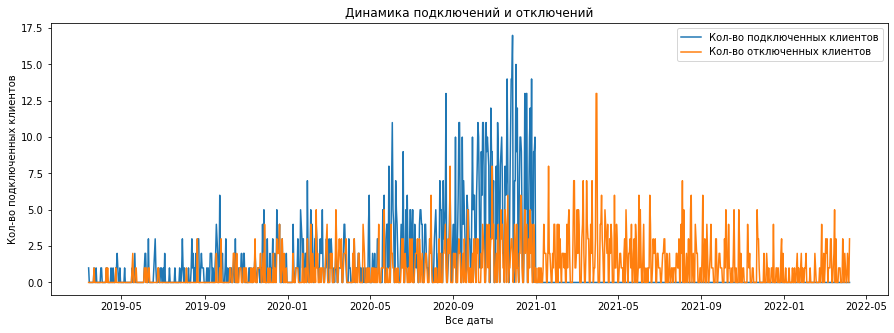

In [58]:
# динамика подключений и отключений
plt.figure(figsize=(15,5))
plt.title('Динамика подключений и отключений')
sns.lineplot(x='Все даты', 
             y='Кол-во подключенных клиентов', 
             data=df_for_visualization.reset_index(), 
             label='Кол-во подключенных клиентов');
sns.lineplot(x='Все даты', 
             y='Кол-во отключенных клиентов', 
             data=df_for_visualization.reset_index(), 
             label='Кол-во отключенных клиентов');

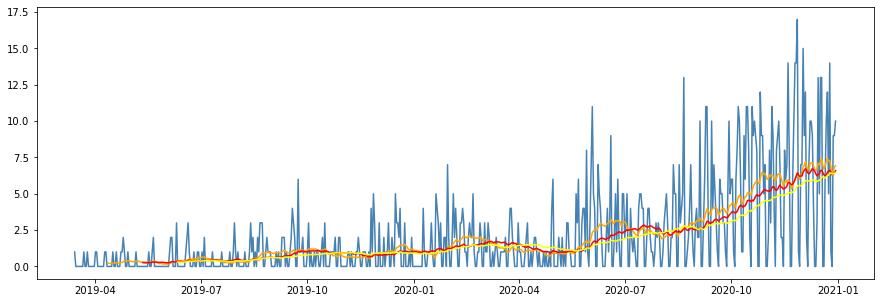

In [59]:
# график с скользящими средними
plt.figure(figsize = (15,5))
plt.plot(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'], 
         color = 'steelblue')
plt.plot(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'].rolling(window = 30).mean(), 
         color = 'orange')
plt.plot(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'].rolling(window = 60).mean(), 
         color = 'red')
plt.plot(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'].rolling(window = 90).mean(), 
         color = 'yellow')
plt.show()

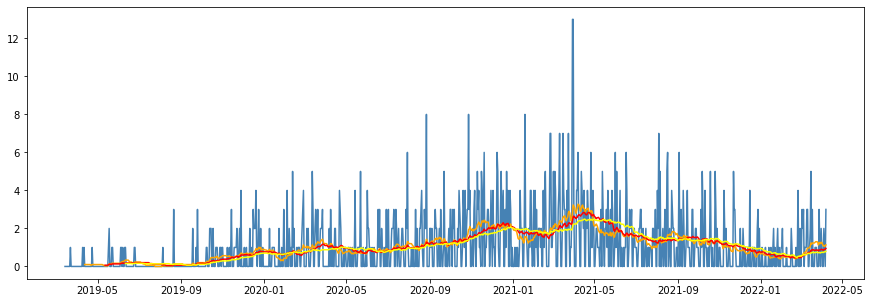

In [60]:
# график с скользящими средними
plt.figure(figsize = (15,5))
plt.plot(df_for_visualization['Кол-во отключенных клиентов'], 
         color = 'steelblue')
plt.plot(df_for_visualization['Кол-во отключенных клиентов'].rolling(window = 30).mean(), 
         color = 'orange')
plt.plot(df_for_visualization['Кол-во отключенных клиентов'].rolling(window = 60).mean(), 
         color = 'red')
plt.plot(df_for_visualization['Кол-во отключенных клиентов'].rolling(window = 90).mean(), 
         color = 'yellow')
plt.show()

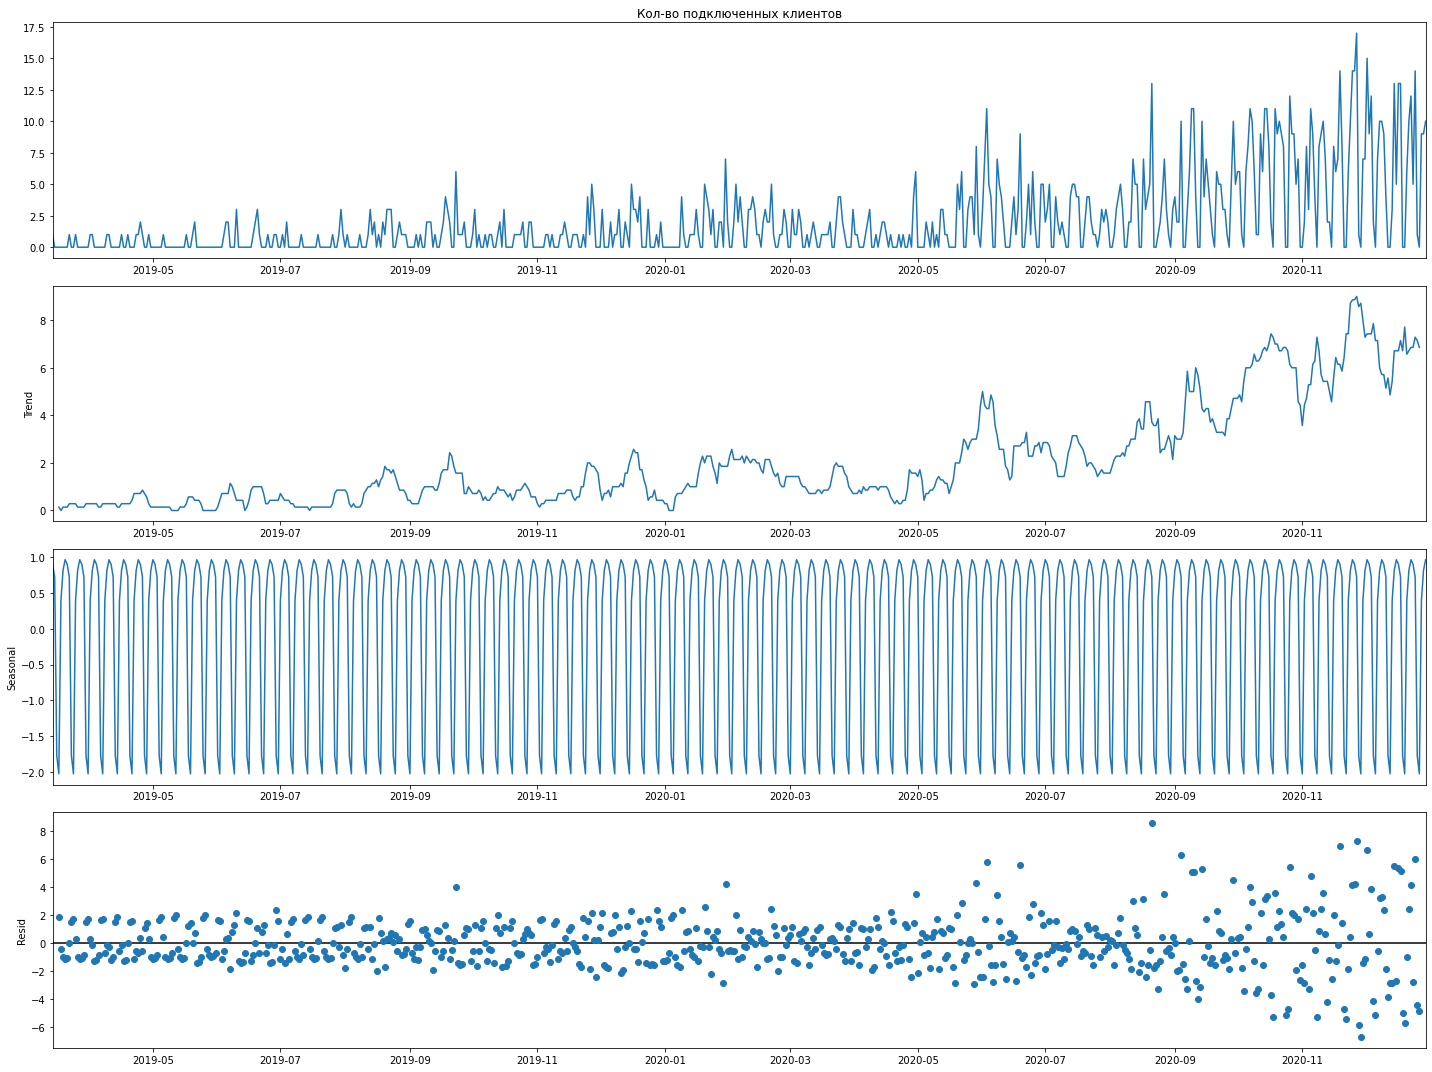

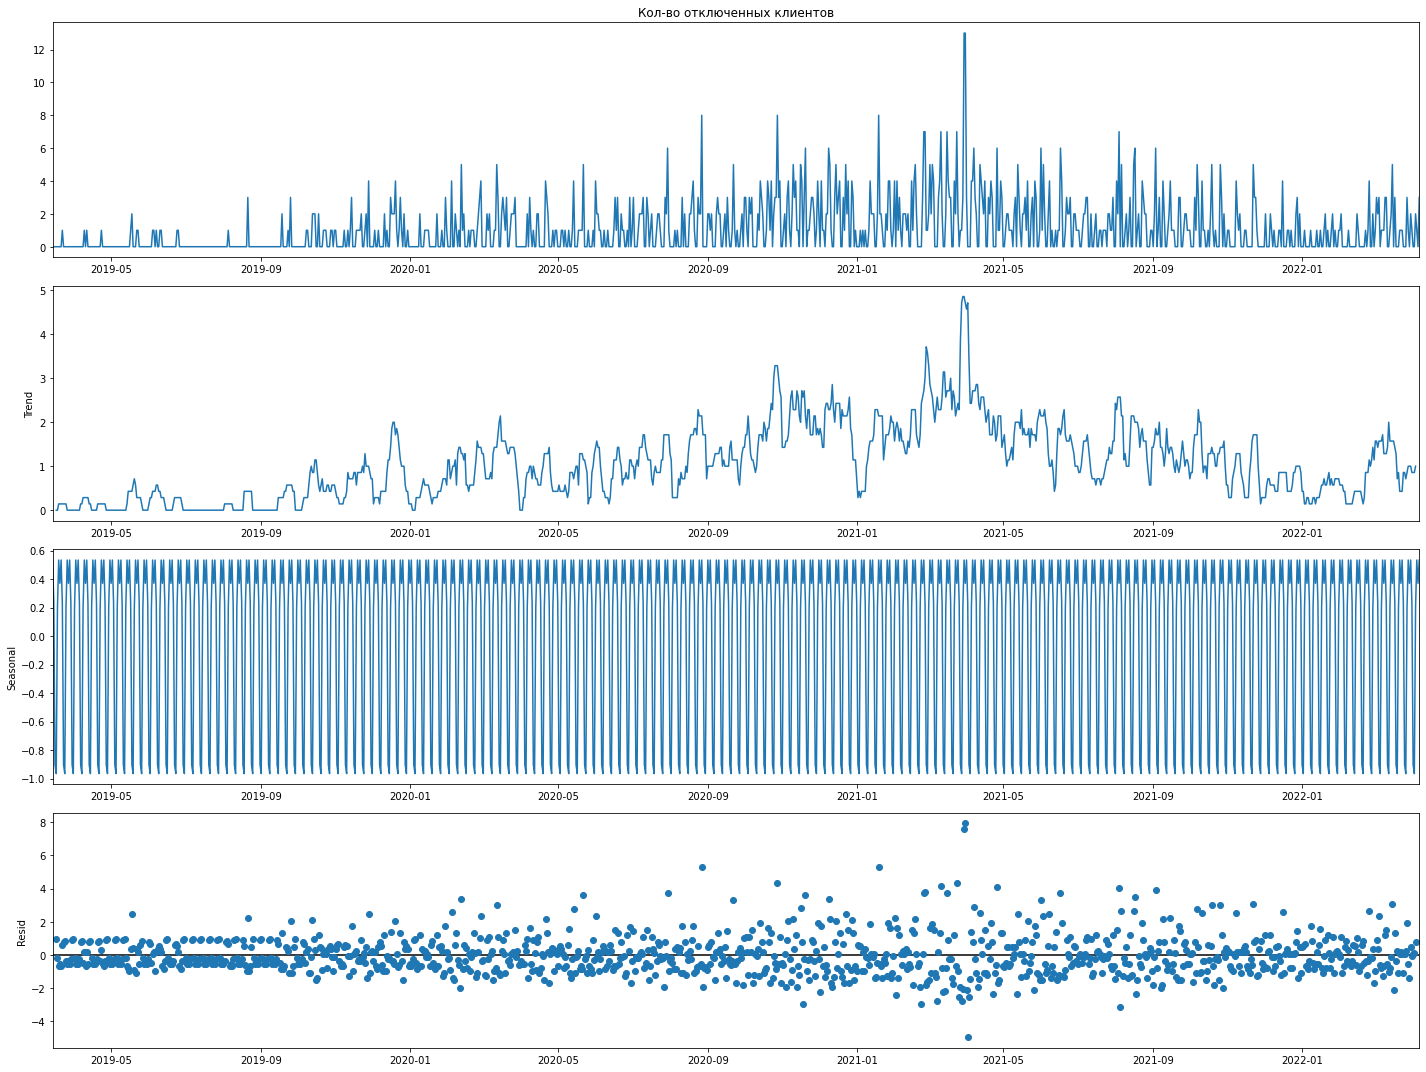

In [61]:
# посмотрим на тренд, сезонность и на случайные колебания (остатки)
from pylab import rcParams
rcParams['figure.figsize'] = 20, 15

decompose = seasonal_decompose(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'])
decompose2 = seasonal_decompose(df_for_visualization['Кол-во отключенных клиентов'])
decompose.plot()
decompose2.plot()
plt.show()

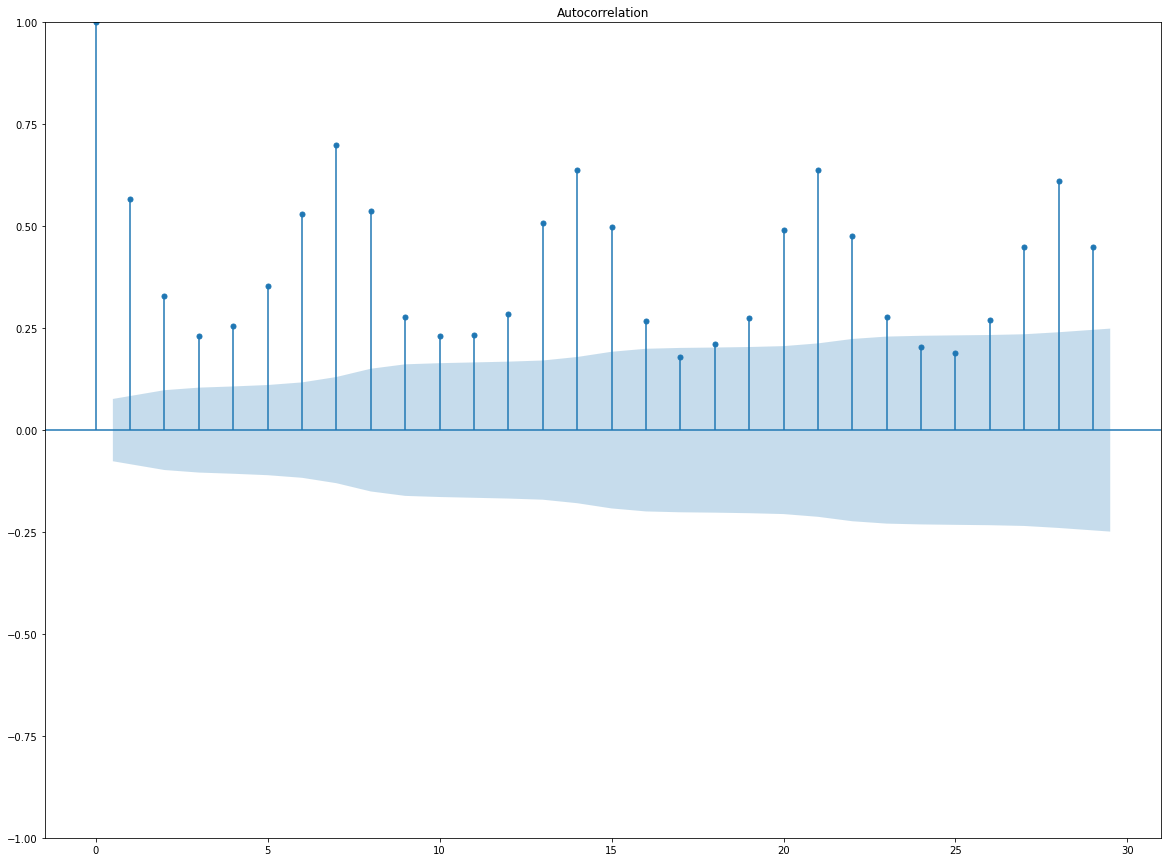

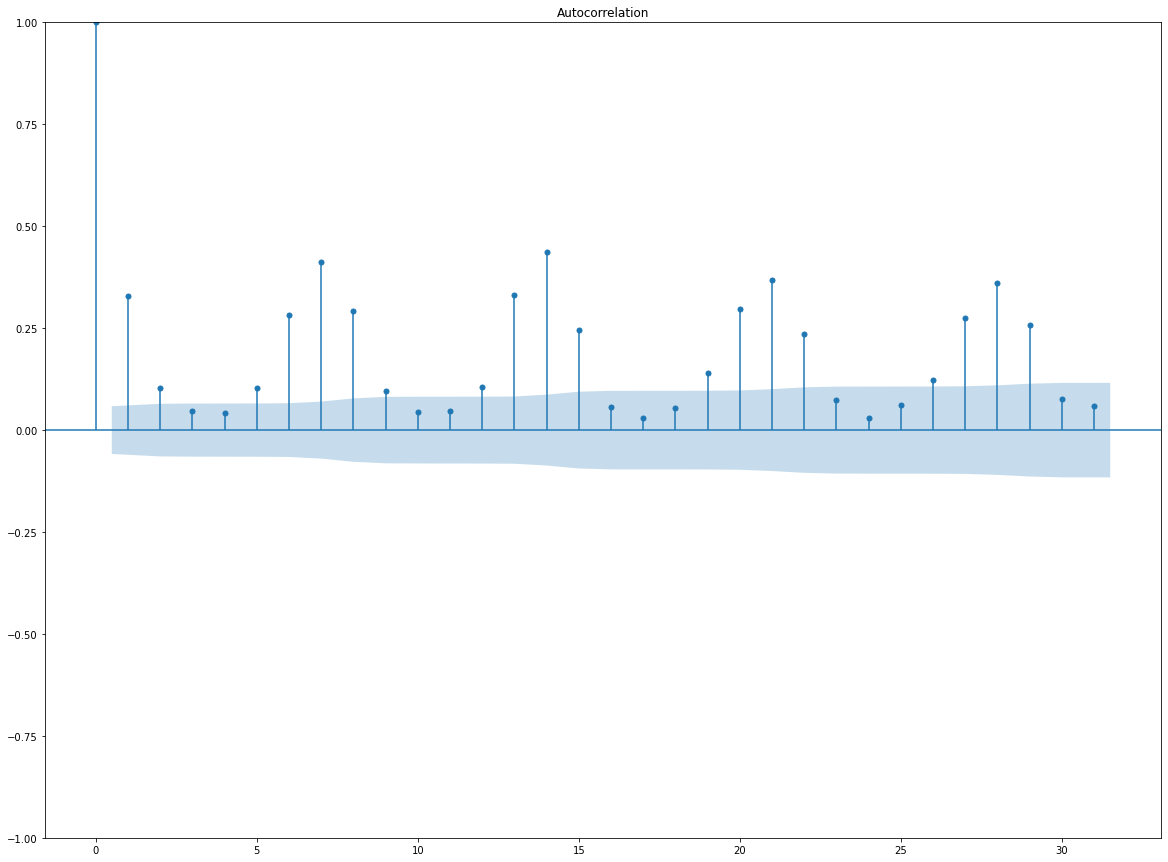

In [62]:
# построение автокорреляционной функции (ACF)
plot_acf(df_for_visualization['Кол-во подключенных клиентов'][:'2020-12-30'])
plot_acf(df_for_visualization['Кол-во отключенных клиентов'])
plt.show()

# Прогнозы

## Создание датафрейма для обучения

In [35]:
# т.к. у подневной разбивки много значений с нулем, построим прогноз на месячной разбивке, 
# создадим для этого новый датафрейм (из датафрейма до визуализации)
df_month = df_all_date.copy()

df_month['Год'] = df_month['Все даты'].apply(lambda x: x.year)
df_month['Месяц'] = df_month['Все даты'].apply(lambda x: x.month)

df_month = df_month.groupby(['Год', 'Месяц']).sum().reset_index()

df_month['Дата'] = ['01 ' + str(i) + ' ' + str(y) for i, y in zip(df_month['Месяц'], df_month['Год'])]
df_month['Дата'] = df_month['Дата'].apply(lambda x: dt.datetime.strptime(x, '%d %m %Y').date())

df_month.set_index('Дата', inplace = True)
df_month.index = pd.to_datetime(df_month.index)
del df_month['Год'], df_month['Месяц']

df_month

,Кол-во подключенных клиентов,Кол-во отключенных клиентов
Дата,,
2019-03-01,3.0,1.0
2019-04-01,12.0,3.0
2019-05-01,5.0,5.0
2019-06-01,18.0,7.0
2019-07-01,11.0,0.0
2019-08-01,28.0,4.0
2019-09-01,32.0,6.0
2019-10-01,24.0,16.0
2019-11-01,25.0,20.0


## Предсказание подключенных клиентов

In [36]:
# создадим модель
model = SARIMAX(df_month['Кол-во подключенных клиентов'][:'2020-12-01'], 
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 12))
 
result = model.fit()

/Users/tatyanagordenko/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/tatyanagordenko/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/tatyanagordenko/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26935D+00    |proj g|=  8.92927D+00

At iterate    5    f=  2.37387D+00    |proj g|=  9.51122D-02

At iterate   10    f=  2.27050D+00    |proj g|=  2.93899D-02

At iterate   15    f=  2.26588D+00    |proj g|=  2.66345D-03

At iterate   20    f=  2.26076D+00    |proj g|=  1.07660D-03

At iterate   25    f=  2.26066D+00    |proj g|=  2.27462D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     31      1     0     0   

In [37]:
# прогнозный период с конца имеющихся данных и до конца 2022 года
start = len(df_month['Кол-во подключенных клиентов'][:'2020-12-01'])
end = 45

forecast = result.predict(start, end)
forecast

2021-01-01    209.640537
2021-02-01    213.409132
2021-03-01    191.590958
2021-04-01    177.378016
2021-05-01    191.475521
2021-06-01    229.796647
2021-07-01    198.337064
2021-08-01    216.094703
2021-09-01    247.061987
2021-10-01    308.230274
2021-11-01    298.591399
2021-12-01    315.137656
2022-01-01    312.502202
2022-02-01    312.165467
2022-03-01    286.405810
2022-04-01    268.408696
2022-05-01    278.873059
2022-06-01    313.706046
2022-07-01    278.897540
2022-08-01    293.439915
2022-09-01    321.320260
2022-10-01    379.524812
2022-11-01    367.040488
2022-12-01    380.854861
Freq: MS, Name: predicted_mean, dtype: float64

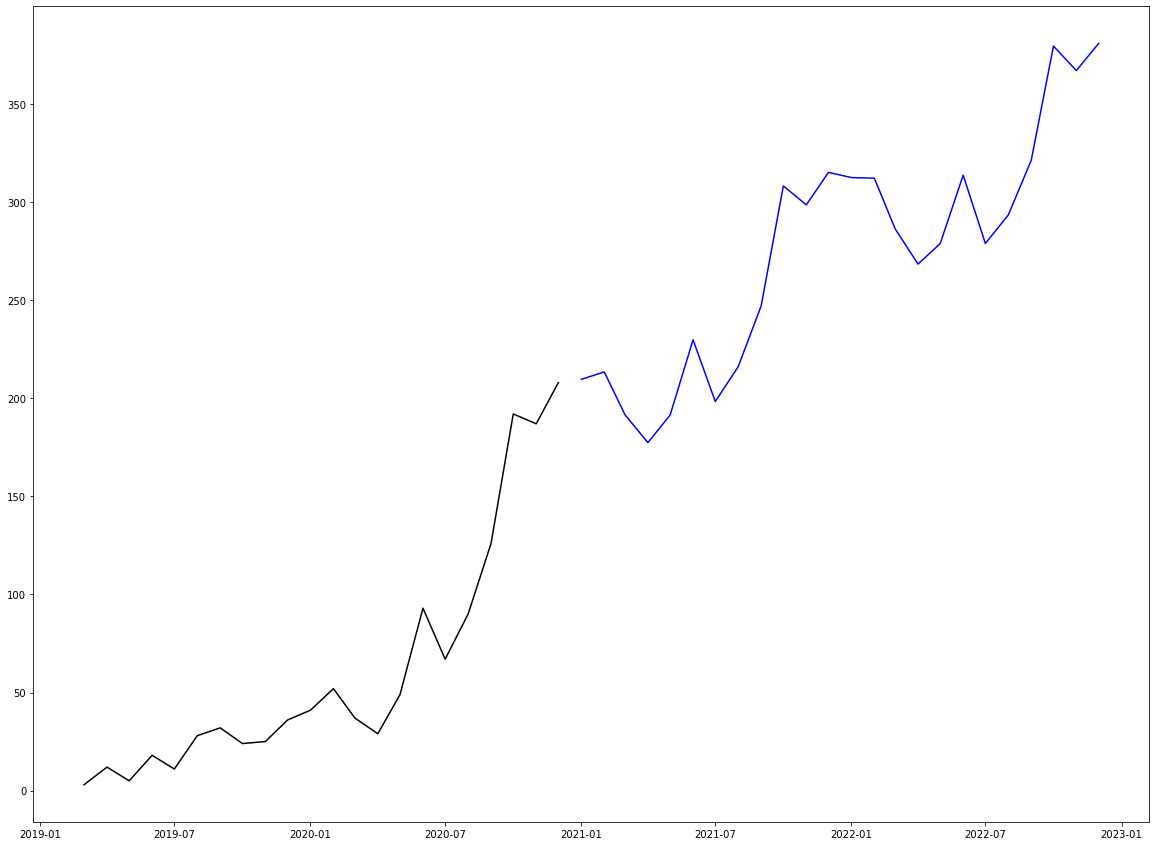

In [38]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(df_month['Кол-во подключенных клиентов'][:'2020-12-01'], color = 'black')
plt.plot(forecast, color = 'blue')
plt.show()

## Предсказание отключенных клиентов 

In [39]:
# создадим модель
model_2 = SARIMAX(df_month['Кол-во отключенных клиентов'][:'2021-12-01'], 
                order = (3, 0, 0), 
                seasonal_order = (0, 1, 0, 12))
 
result_2 = model_2.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74800D+00    |proj g|=  8.07060D-03

At iterate    5    f=  2.74621D+00    |proj g|=  6.16627D-03

At iterate   10    f=  2.74580D+00    |proj g|=  3.26941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   3.766D-06   2.746D+00
  F =   2.7457798758694643     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/tatyanagordenko/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/tatyanagordenko/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


In [40]:
# прогнозный период с конца имеющихся данных и до конца 2022 года
start_2 = len(df_month['Кол-во отключенных клиентов'])
end_2 = 45

forecast_2 = result_2.predict(start_2, end_2)
forecast_2

2022-05-01    22.158531
2022-06-01    27.211438
2022-07-01    11.062209
2022-08-01    32.779563
2022-09-01    23.360165
2022-10-01    22.807668
2022-11-01    10.135947
2022-12-01     8.355817
Freq: MS, Name: predicted_mean, dtype: float64

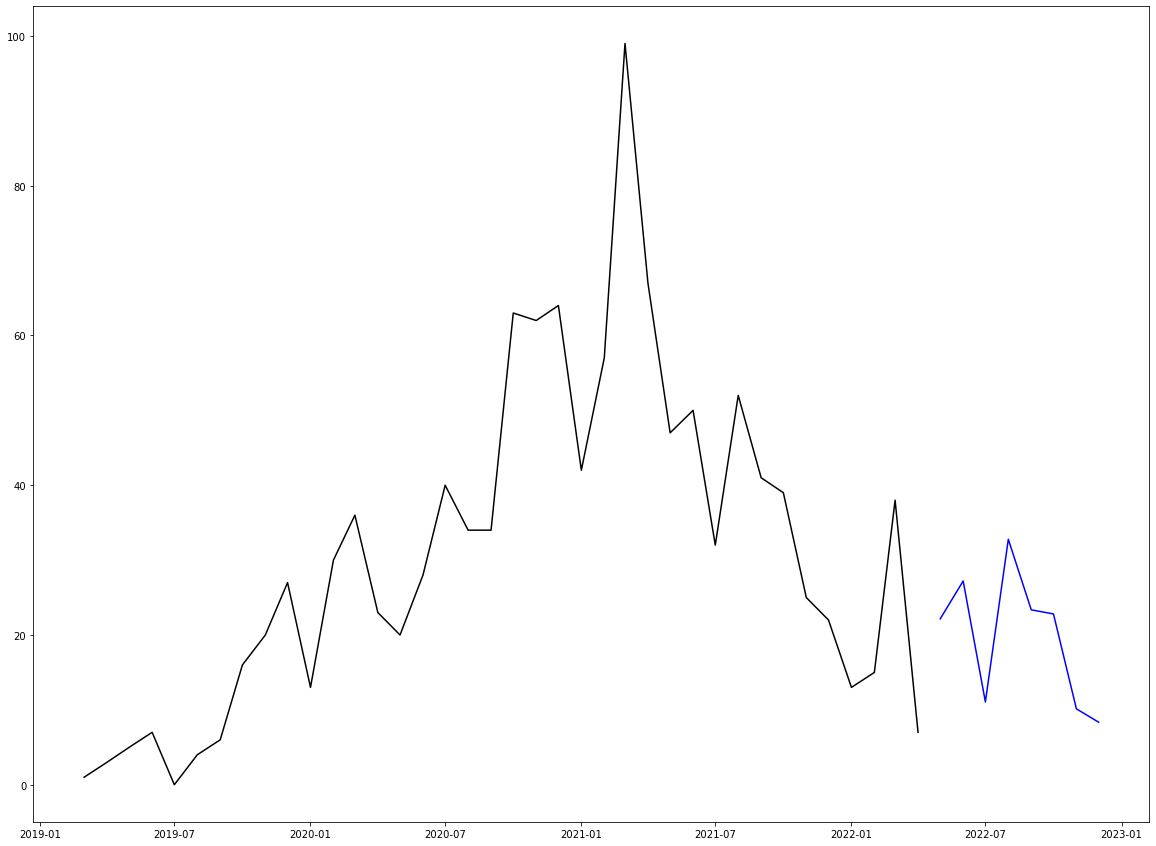

In [41]:
# выведем две кривые (фактические данные и прогноз на будущее)
plt.plot(df_month['Кол-во отключенных клиентов'], color = 'black')
plt.plot(forecast_2, color = 'blue')
plt.show()

## Объединение предсказаний

In [42]:
df_forecast = pd.DataFrame(round(forecast))
df_forecast_2 = pd.DataFrame(round(forecast_2))

In [43]:
df_month = df_month.merge(df_forecast, left_index=True, right_index=True, how='outer').merge(
    df_forecast_2, left_index=True, right_index=True, how='left')

df_month = df_month.fillna(0)

df_month['Кол-во подключенных клиентов'] = df_month['Кол-во подключенных клиентов'] + df_month['predicted_mean_x']
df_month['Кол-во отключенных клиентов'] = df_month['Кол-во отключенных клиентов'] + df_month['predicted_mean_y']

del df_month['predicted_mean_x'], df_month['predicted_mean_y']

df_month

,Кол-во подключенных клиентов,Кол-во отключенных клиентов
2019-03-01,3.0,1.0
2019-04-01,12.0,3.0
2019-05-01,5.0,5.0
2019-06-01,18.0,7.0
2019-07-01,11.0,0.0
2019-08-01,28.0,4.0
2019-09-01,32.0,6.0
2019-10-01,24.0,16.0
2019-11-01,25.0,20.0
2019-12-01,36.0,27.0


## Вычисление сальдо

In [44]:
res = 0
arr = []
for i, y in zip(df_month['Кол-во подключенных клиентов'], df_month['Кол-во отключенных клиентов']):
    res = res + i - y
    arr.append(res)
    
df_month['Сальдо'] = arr
df_month

,Кол-во подключенных клиентов,Кол-во отключенных клиентов,Сальдо
2019-03-01,3.0,1.0,2.0
2019-04-01,12.0,3.0,11.0
2019-05-01,5.0,5.0,11.0
2019-06-01,18.0,7.0,22.0
2019-07-01,11.0,0.0,33.0
2019-08-01,28.0,4.0,57.0
2019-09-01,32.0,6.0,83.0
2019-10-01,24.0,16.0,91.0
2019-11-01,25.0,20.0,96.0
2019-12-01,36.0,27.0,105.0


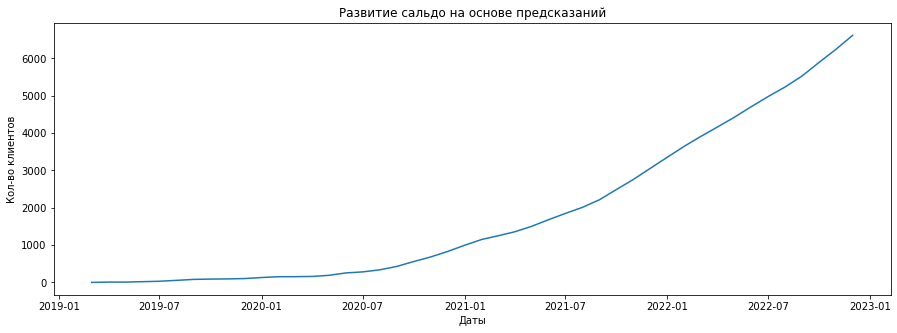

In [45]:
# динамика сальдо
plt.figure(figsize = (15,5))
plt.title('Развитие сальдо на основе предсказаний')
plt.xlabel('Даты')
plt.ylabel('Кол-во клиентов')
plt.plot(df_month['Сальдо'])
plt.show()

In [46]:
df_month.to_csv('Месячные предсказания.csv')